In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and preprocess data
data = pd.read_csv('breast_cancer_data.csv')
data.drop('id', axis=1, inplace=True)
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']


In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



In [4]:
# Feature selection with RFE
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)
selected_features = X.columns[rfe_selector.support_].tolist()
print("\nSelected Features (Top 10 by RFE):", selected_features)



Selected Features (Top 10 by RFE): ['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [5]:
# Scaling
scaler = StandardScaler()
X_train_rfe_scaled = scaler.fit_transform(X_train_rfe)
X_test_rfe_scaled = scaler.transform(X_test_rfe)


In [6]:
# Base models
base_models = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')),
    ('svm', SVC(random_state=42, probability=True, kernel='rbf')),
    ('rf', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)),
    ('xgb', XGBClassifier(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.2, eval_metric='logloss')),
    ('mlp', MLPClassifier(random_state=42, hidden_layer_sizes=(100,), max_iter=200))
]



In [7]:
# Stacking ensemble
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)


In [8]:
# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)),
    ('stacking', stacking_model)
])


In [9]:
# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')

print("\nStacking Ensemble Performance:")
print("-" * 50)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"CV Accuracy (5-fold): {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"ROC-AUC: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))


Stacking Ensemble Performance:
--------------------------------------------------
Test Accuracy: 0.9737
CV Accuracy (5-fold): 0.9582 (±0.0189)
ROC-AUC: 0.9980

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [13]:
# Convert RFE-transformed test set to DataFrame with selected feature names
X_test_rfe_df = pd.DataFrame(X_test_rfe, columns=selected_features)

# Train Random Forest on RFE-selected features
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)
rf_model.fit(X_train_rfe, y_train)

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_rfe_df)

# Check if shap_values is a list (multi-class or binary with per-class output)
if isinstance(shap_values, list):
    shap_summary = shap_values[1]  # Class 1: Malignant
else:
    shap_summary = shap_values     # Single array output




SHAP Feature Importance (Random Forest):


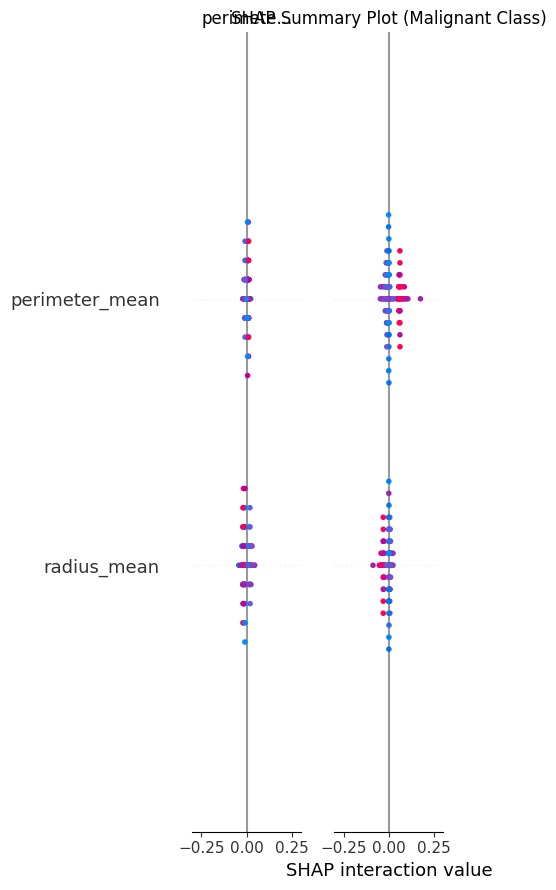

In [15]:
# Plot SHAP summary
print("\nSHAP Feature Importance (Random Forest):")
shap.summary_plot(shap_summary, X_test_rfe_df, feature_names=selected_features, max_display=10, show=False)
plt.title('SHAP Summary Plot (Malignant Class)')
plt.tight_layout()
plt.show()


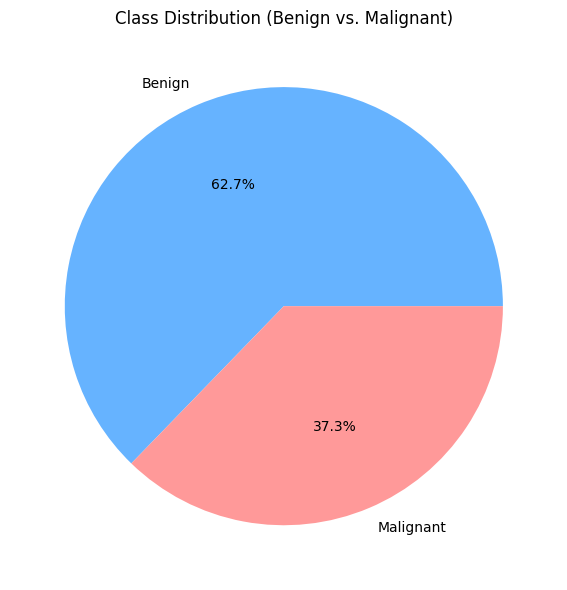

In [16]:
# Class Distribution
plt.figure(figsize=(6, 6))
y.value_counts().plot.pie(labels=['Benign', 'Malignant'], autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Class Distribution (Benign vs. Malignant)')
plt.ylabel('')
plt.tight_layout()
plt.show()


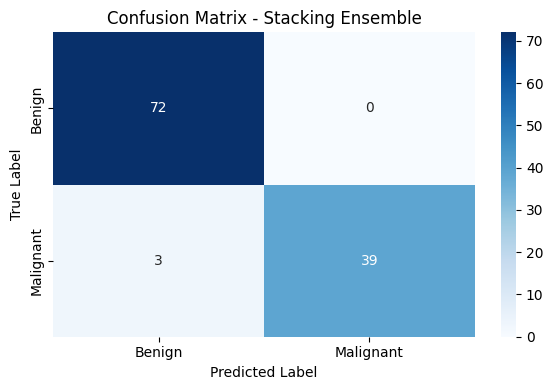

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Stacking Ensemble')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


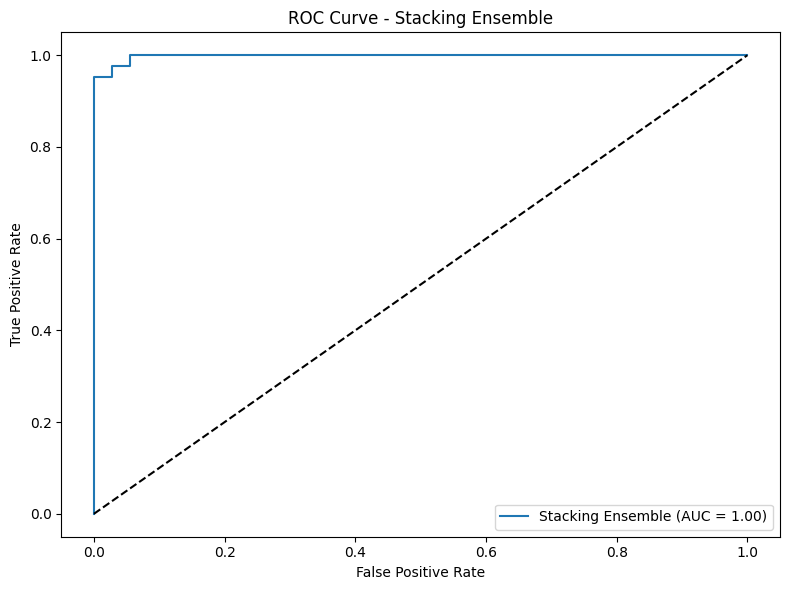

In [18]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Stacking Ensemble (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Ensemble')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


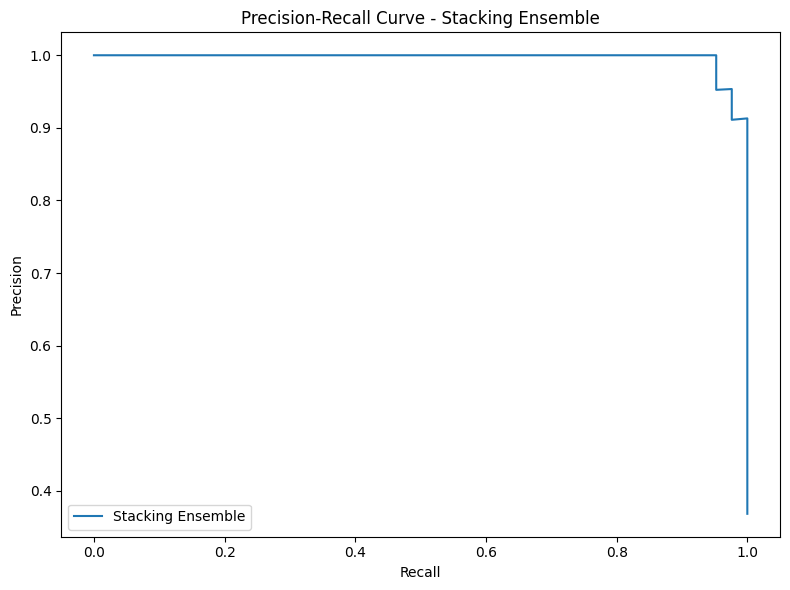

In [19]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Stacking Ensemble')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Stacking Ensemble')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


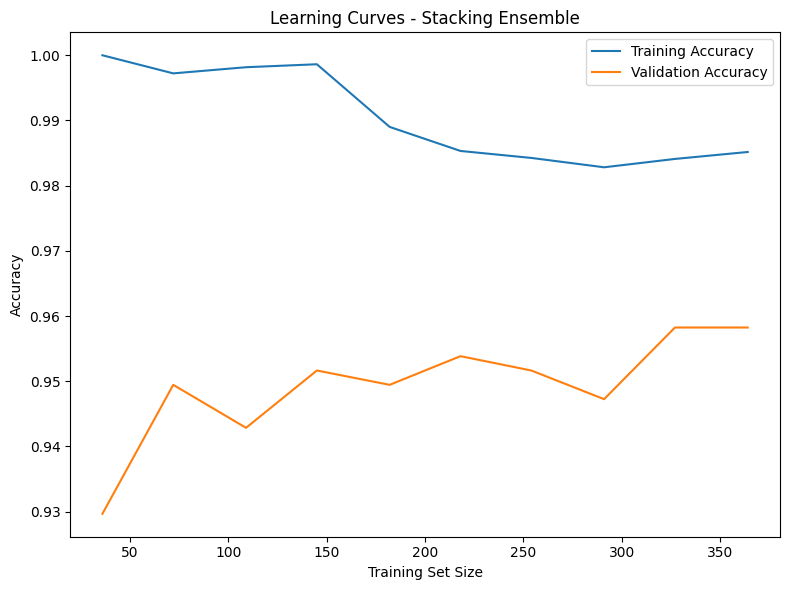

In [20]:
# Learning Curves
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves - Stacking Ensemble')
plt.legend(loc="best")
plt.tight_layout()
plt.show()


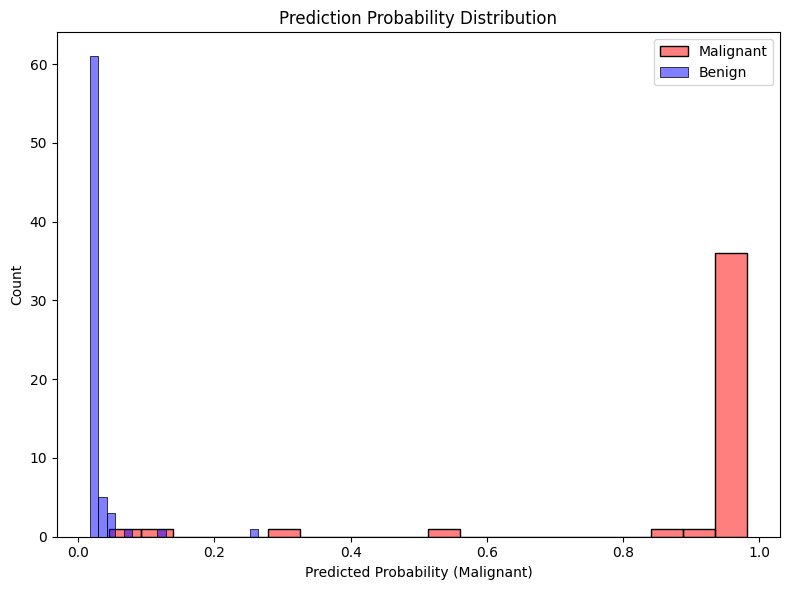

In [21]:
# Prediction Probability Histogram
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_test == 1], color='red', label='Malignant', alpha=0.5, bins=20)
sns.histplot(y_pred_proba[y_test == 0], color='blue', label='Benign', alpha=0.5, bins=20)
plt.xlabel('Predicted Probability (Malignant)')
plt.ylabel('Count')
plt.title('Prediction Probability Distribution')
plt.legend()
plt.tight_layout()
plt.show()



In [22]:
# Error Analysis
misclassified = X_test[y_test != y_pred].index
print("\nMisclassified Samples (Indices):", misclassified.tolist())
if len(misclassified) > 0:
    print("\nFeatures of First Misclassified Sample:")
    print(X_test.loc[misclassified[0]])



Misclassified Samples (Indices): [73, 86, 205]

Features of First Misclassified Sample:
radius_mean                 13.800000
texture_mean                15.790000
perimeter_mean              90.430000
area_mean                  584.100000
smoothness_mean              0.100700
compactness_mean             0.128000
concavity_mean               0.077890
concave points_mean          0.050690
symmetry_mean                0.166200
fractal_dimension_mean       0.065660
radius_se                    0.278700
texture_se                   0.620500
perimeter_se                 1.957000
area_se                     23.350000
smoothness_se                0.004717
compactness_se               0.020650
concavity_se                 0.017590
concave points_se            0.009206
symmetry_se                  0.012200
fractal_dimension_se         0.003130
radius_worst                16.570000
texture_worst               20.860000
perimeter_worst            110.300000
area_worst                 812.400000

In [24]:
# Correct Feature Importance Extraction
rf_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importance (Random Forest):")
print(rf_importance.head(10))




Top 10 Feature Importance (Random Forest):
                Feature  Importance
7       perimeter_worst    0.203265
5          radius_worst    0.167324
4   concave points_mean    0.152399
8            area_worst    0.150038
9  concave points_worst    0.148496
3        concavity_mean    0.044933
6         texture_worst    0.040733
0           radius_mean    0.035493
2             area_mean    0.033928
1        perimeter_mean    0.023392
